<a href="https://colab.research.google.com/github/TienDat11/report-big-data/blob/main/Case2_ThiCuoiKy_BigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Phân cụm cá nhân dựa trên đặc điểm nhân khẩu học
Trong bài nghiên cứu này, chúng ta sẽ áp dụng các phương pháp phân cụm (clustering methods) để nhận diện và phân loại các nhóm nhà đầu tư khác nhau dựa trên dữ liệu có sẵn.

## Nội dung

* [1. Định nghĩa vấn đề](#0)
* [2. Khởi tạo - Tải thư viện và Dữ liệu](#1)
    * [2.1. Tải thư viện](#1.1)
    * [2.2. Tải bộ dữ liệu](#1.2)
* [3. Phân tích Khám phá Dữ liệu (EDA)](#2)
    * [3.1 Thống kê mô tả](#2.1)
    * [3.2. Trực quan hóa dữ liệu](#2.2)
* [4. Chuẩn bị dữ liệu](#3)
    * [4.1 Làm sạch dữ liệu](#3.1)
    * [4.2. Chuyển đổi dữ liệu](#3.2)
* [5. Đánh giá Thuật toán và Mô hình](#5)
    * [5.1. Phân cụm k-Means](#5.1)
        * [5.1.1 Tìm số lượng cụm tối ưu](#5.1.1)
    * [5.2. Phân cụm Affinity Propagation (Lan truyền hấp dẫn)](#5.2)
    * [5.3. Đánh giá kết quả phân cụm](#5.3)
* [6. Thấu hiểu bản chất Cụm (Cluster Intuition)](#6)

<a id='0'></a>
# 1. Định nghĩa vấn đề

Mục tiêu cốt lõi của nghiên cứu này là xây dựng một mô hình học máy (machine learning model) nhằm phân cụm các cá nhân/nhà đầu tư dựa trên các tham số liên quan đến **khả năng** và **sự sẵn lòng** chấp nhận rủi ro. Chúng ta sẽ tập trung sử dụng các đặc điểm nhân khẩu học và tài chính phổ biến để thực hiện điều này.

Dữ liệu được sử dụng trong bài toán này được trích xuất từ **Khảo sát Tài chính Tiêu dùng (Survey of Consumer Finances)** do Cục Dự trữ Liên bang Hoa Kỳ thực hiện. Đây là bộ dữ liệu tiêu chuẩn đã được đề cập trong các nghiên cứu tình huống ở chương 5 và chương 6.

<a id='1'></a>
# 2. Khởi tạo - Tải dữ liệu và các gói thư viện Python

<a id='1.1'></a>
## 2.1. Tải các gói thư viện Python

In [47]:
# Tải các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime

# Nhập các gói mô hình phân cụm
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


# Các gói và hàm hỗ trợ khác
import matplotlib.ticker as ticker
from itertools import cycle

<a id='1.2'></a>
## 2.2. Tải bộ dữ liệu

Bộ dữ liệu này tương đồng với dữ liệu gốc đã được sử dụng trước đó, tuy nhiên đã qua xử lý tiền kỳ để cung cấp các thuộc tính (attributes) cụ thể cho các nhà đầu tư khác nhau trong năm 2007.

In [48]:
# Tải tập dữ liệu từ file Excel
dataset = pd.read_excel('ProcessedData.xlsx')

In [49]:
# Tắt các cảnh báo
import warnings
warnings.filterwarnings('ignore')

In [50]:
type(dataset) # Kiểm tra kiểu dữ liệu của biến dataset

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Phân tích Khám phá Dữ liệu (Exploratory Data Analysis - EDA)

<a id='2.1'></a>
## 3.1. Thống kê mô tả

In [51]:
# Hiển thị kích thước của tập dữ liệu (số hàng, số cột)
dataset.shape

(3866, 13)

In [52]:
# Xem qua 5 dòng dữ liệu đầu tiên
set_option('display.width', 100)
dataset.head(5)

,ID,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
0,1,3,2,1,0,2,1,3,1,1,5,3,4
1,2,4,4,1,2,5,2,3,0,2,5,5,5
2,3,3,1,1,2,3,2,2,1,2,4,4,4
3,4,3,1,1,2,3,2,2,1,2,4,3,4
4,5,4,3,1,1,5,1,2,1,3,3,5,5


Như quan sát trong bảng trên, mỗi cá nhân có 12 thuộc tính đi kèm. Các thuộc tính này có thể được phân loại thành ba nhóm chính:
1.  **Thuộc tính nhân khẩu học (Demographic)**
2.  **Thuộc tính tài chính (Financial)**
3.  **Thuộc tính hành vi (Behavioral)**

In [53]:
# Mô tả thống kê các cột trong tập dữ liệu
pd.set_option('display.precision', 3)
dataset.describe()

,ID,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
count,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000
mean,1933.500,3.107,2.906,1.353,0.938,3.697,1.742,3.043,0.717,2.446,3.561,2.976,3.671
std,1116.162,1.513,1.066,0.478,1.249,1.618,0.934,0.879,0.451,0.743,1.304,1.463,1.184
min,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000
25%,967.250,2.000,2.000,1.000,0.000,3.000,1.000,2.000,0.000,2.000,2.000,2.000,3.000
50%,1933.500,3.000,3.000,1.000,0.000,3.000,1.000,3.000,1.000,3.000,4.000,3.000,4.000
75%,2899.750,4.000,4.000,2.000,2.000,5.000,3.000,4.000,1.000,3.000,5.000,4.000,5.000
max,3866.000,6.000,4.000,2.000,8.000,6.000,4.000,4.000,1.000,3.000,5.000,5.000,5.000


<a id='2.2'></a>
## 3.2. Trực quan hóa dữ liệu

Chúng ta sẽ xem xét mối tương quan (correlation) giữa các biến. Việc trực quan hóa chi tiết sẽ được thực hiện kỹ hơn sau khi đã hoàn thành quá trình phân cụm.

<Axes: title={'center': 'Ma trận tương quan'}>

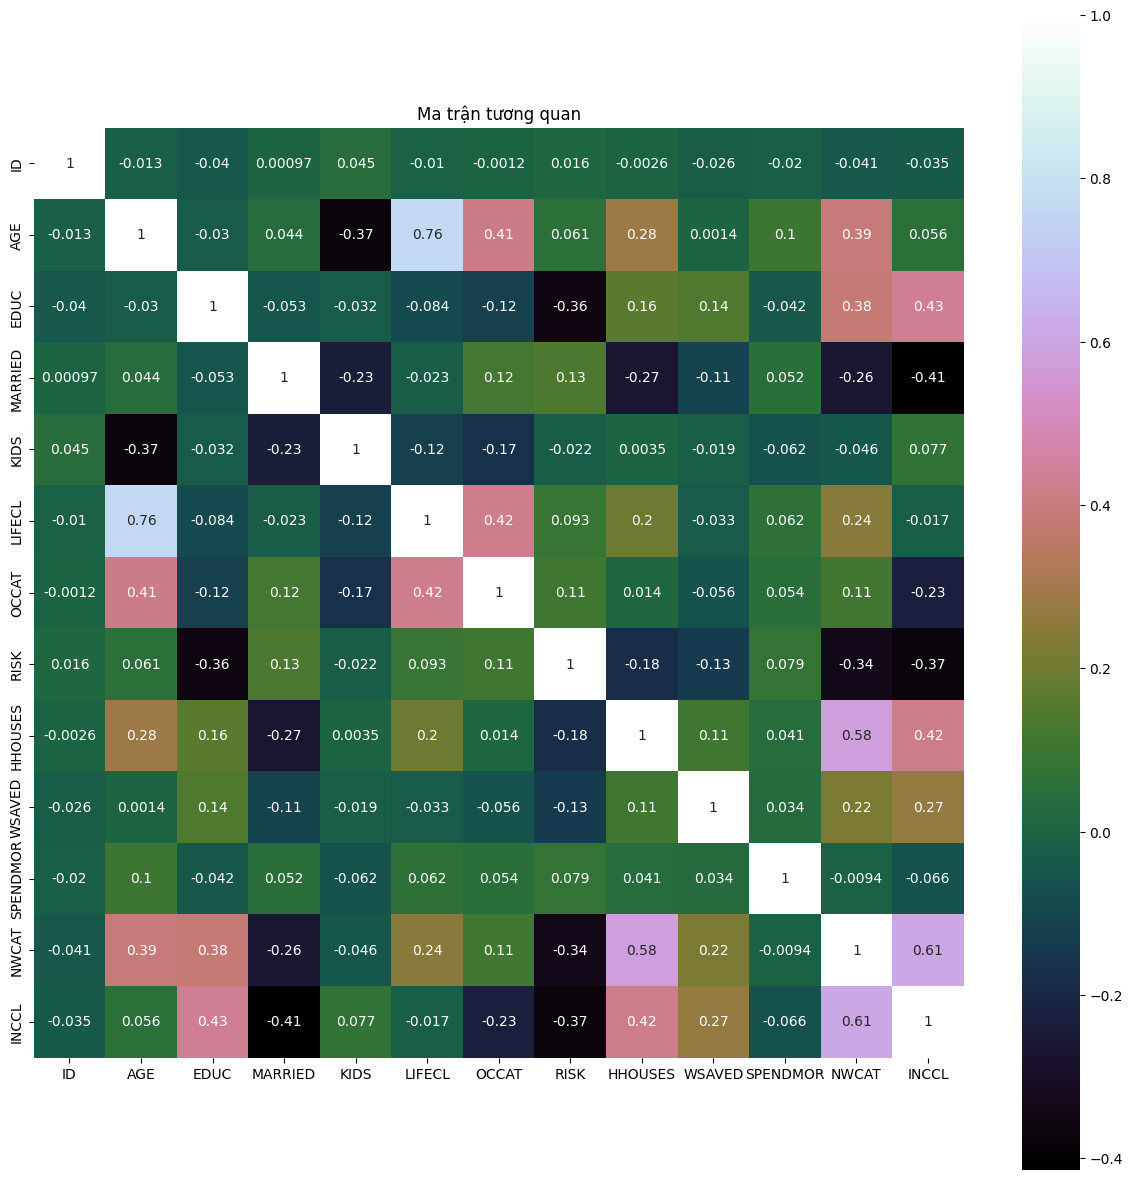

In [54]:
# Tính toán ma trận tương quan
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Ma trận tương quan') # Đặt tiêu đề cho biểu đồ
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Như hình ảnh trên hiển thị, có một sự tương quan dương đáng kể giữa các biến số đầu tư (stocks).

<a id='3'></a>
# 4. Chuẩn bị dữ liệu

<a id='3.1'></a>
## 4.1. Làm sạch dữ liệu (Data Cleaning)
Chúng ta hãy kiểm tra các giá trị bị thiếu (NA) trong các hàng, sau đó quyết định loại bỏ chúng hay điền vào bằng giá trị trung bình của cột.

In [55]:
# Kiểm tra xem có bất kỳ giá trị rỗng nào trong tập dữ liệu hay không
print('Có giá trị rỗng =', dataset.isnull().values.any())

Có giá trị rỗng = False


Vì không có dữ liệu bị thiếu và dữ liệu đã ở định dạng phân loại (categorical format) nên không cần thực hiện thêm bước làm sạch nào. Cột ID không cần thiết cho mô hình nên đã bị loại bỏ.

In [56]:
X = dataset.copy("deep") # Tạo một bản sao sâu của tập dữ liệu để làm việc
X = X.drop(['ID'], axis=1) # Loại bỏ cột 'ID' vì nó không cần thiết cho việc phân cụm
X.head() # Hiển thị 5 dòng dữ liệu đầu tiên sau khi loại bỏ cột 'ID'

,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
0,3,2,1,0,2,1,3,1,1,5,3,4
1,4,4,1,2,5,2,3,0,2,5,5,5
2,3,1,1,2,3,2,2,1,2,4,4,4
3,3,1,1,2,3,2,2,1,2,4,3,4
4,4,3,1,1,5,1,2,1,3,3,5,5


<a id='3.2'></a>
## 4.2. Chuyển đổi dữ liệu (Data Transformation)

Dữ liệu hiện có bao gồm các thuộc tính có thang đo tương tự nhau. Do đó, không cần yêu cầu chuyển đổi dữ liệu (data transformation).

<a id='4'></a>
# 5. Đánh giá Thuật toán và Mô hình

Trong bước này, chúng ta sẽ xem xét các mô hình sau và thực hiện phân tích, trực quan hóa sâu hơn:
1.  **K-means**
2.  **Affinity Propagation** (Lan truyền hấp dẫn)

<a id='5.1'></a>
## 5.1. Phân cụm k-Means (k-Means Clustering)

Ở bước này, chúng ta sẽ xem xét các chỉ số sau để xác định số lượng cụm tối ưu:
1.  **Tổng bình phương sai số (SSE)** trong các cụm.
2.  **Hệ số dáng điệu (Silhouette score)**.

<a id='5.1.1'></a>
### 5.1.1. Tìm số lượng cụm tối ưu

Thông thường, hai chỉ số được sử dụng để đánh giá số lượng cụm trong mô hình K-means là:
1.  Tổng bình phương sai số (SSE) trong các cụm.
2.  Hệ số Silhouette.

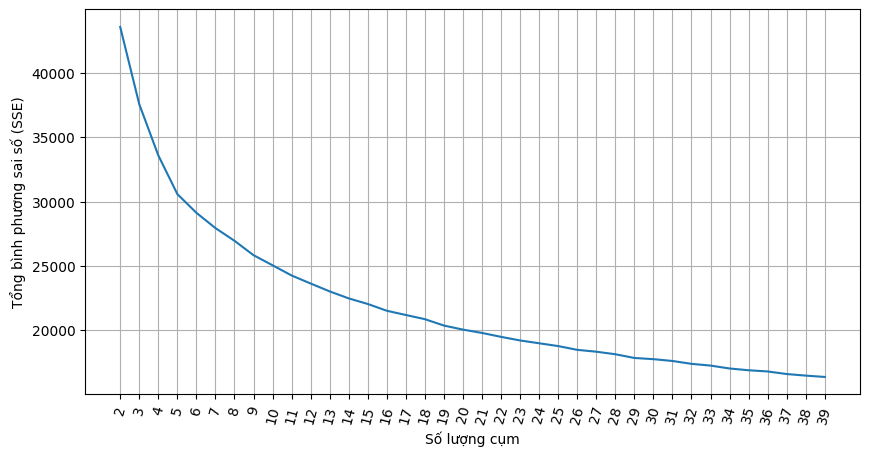

In [57]:
distorsions = [] # Danh sách lưu trữ tổng bình phương sai số
max_loop = 40 # Số lượng cụm tối đa để thử nghiệm
for k in range(2, max_loop): # Lặp từ 2 đến max_loop-1 cụm
    k_means = KMeans(n_clusters=k, random_state=42, n_init=10) # Khởi tạo mô hình KMeans với random_state để tái lập kết quả
    k_means.fit(X) # Huấn luyện mô hình với dữ liệu
    distorsions.append(k_means.inertia_) # Thêm SSE của cụm hiện tại vào danh sách
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, max_loop), distorsions) # Vẽ biểu đồ SSE theo số lượng cụm
plt.xticks([i for i in range(2, max_loop)], rotation=75) # Đặt nhãn trục x
plt.xlabel("Số lượng cụm") # Nhãn trục x
plt.ylabel("Tổng bình phương sai số (SSE)") # Nhãn trục y
plt.grid(True) # Hiển thị lưới

#### Hệ số Silhouette (Silhouette score)

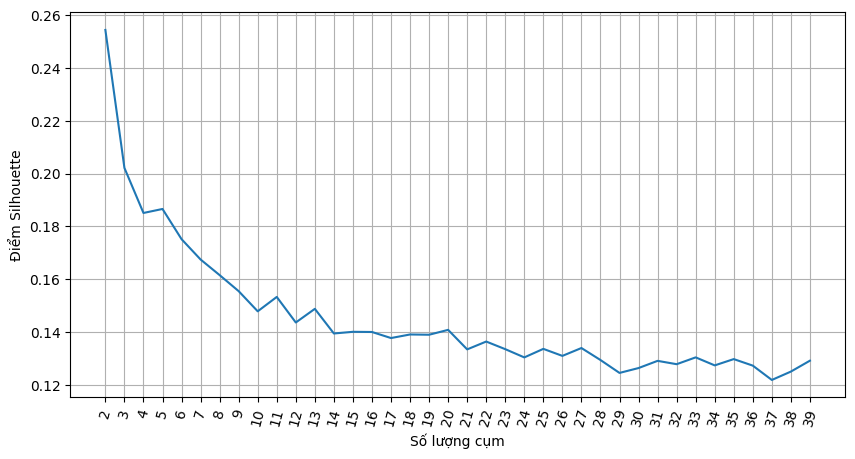

In [58]:
from sklearn import metrics

silhouette_scores = [] # Danh sách lưu trữ điểm Silhouette
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10) # Khởi tạo mô hình KMeans
        kmeans.fit(X) # Huấn luyện mô hình
        silhouette_scores.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10)) # Tính và lưu điểm Silhouette
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, max_loop), silhouette_scores) # Vẽ biểu đồ điểm Silhouette theo số lượng cụm
plt.xticks([i for i in range(2, max_loop)], rotation=75) # Đặt nhãn trục x
plt.xlabel("Số lượng cụm") # Nhãn trục x
plt.ylabel("Điểm Silhouette") # Nhãn trục y
plt.grid(True) # Hiển thị lưới

Nhìn vào cả hai biểu đồ trên, số lượng cụm tối ưu dường như nằm ở khoảng **7**.
* Chúng ta có thể thấy rằng khi số lượng cụm tăng vượt quá 6, tổng bình phương sai số (SSE) bắt đầu bão hòa (plateaus off).
* Từ biểu đồ thứ hai, ta thấy có nhiều điểm gãy khúc (kink).
* Vì không có nhiều sự khác biệt về SSE sau 7 cụm, chúng ta sẽ sử dụng **7 cụm** cho mô hình k-means bên dưới.

<a id='5.1.2'></a>
### 5.1.2. Phân cụm và Trực quan hóa

In [59]:
nclust = 7 # Định nghĩa số lượng cụm tối ưu là 7

In [60]:
# Huấn luyện mô hình K-means với số cụm đã chọn
k_means = cluster.KMeans(n_clusters=nclust, random_state=42, n_init=10) # Khởi tạo KMeans với 7 cụm và random_state để đảm bảo tái lập kết quả
k_means.fit(X) # Huấn luyện mô hình với dữ liệu

KMeans(n_clusters=7, n_init=10, random_state=42)

In [61]:
# Trích xuất nhãn cụm cho mỗi điểm dữ liệu
target_labels = k_means.predict(X) # Dự đoán cụm cho từng điểm trong tập dữ liệu X

<a id='5.2'></a>
## 5.2. Phân cụm Affinity Propagation

In [62]:
ap = AffinityPropagation(damping=0.5, max_iter=250, affinity='euclidean', random_state=42) # Khởi tạo mô hình Affinity Propagation với random_state để đảm bảo tái lập kết quả
ap.fit(X) # Huấn luyện mô hình với dữ liệu
clust_labels2 = ap.predict(X) # Dự đoán nhãn cụm cho từng điểm dữ liệu

In [63]:
cluster_centers_indices = ap.cluster_centers_indices_ # Lấy chỉ số của các điểm đại diện cụm (exemplars)
labels = ap.labels_ # Lấy nhãn cụm cho mỗi điểm dữ liệu
n_clusters_ = len(cluster_centers_indices) # Tính số lượng cụm ước tính
print('Số lượng cụm ước tính: %d' % n_clusters_)

Số lượng cụm ước tính: 161


<a id='5.3'></a>
## 5.3. Đánh giá kết quả phân cụm

Chúng ta đánh giá các cụm bằng cách sử dụng **Hệ số Silhouette** (`sklearn.metrics.silhouette_score`). Hệ số Silhouette càng cao đồng nghĩa với việc các cụm được định nghĩa càng rõ ràng và tách biệt tốt hơn.

In [64]:
from sklearn import metrics
print("K-Means Silhouette Score:", metrics.silhouette_score(X, k_means.labels_, metric='euclidean')) # In điểm Silhouette của K-Means
print("Affinity Propagation Silhouette Score:", metrics.silhouette_score(X, ap.labels_, metric='euclidean')) # In điểm Silhouette của Affinity Propagation

K-Means Silhouette Score: 0.17132216716820192
Affinity Propagation Silhouette Score: 0.09690483039906135


Kết quả cho thấy **k-means** có Hệ số Silhouette cao hơn nhiều so với **Affinity Propagation**.

<a id='6'></a>
# 6. Thấu hiểu bản chất Cụm (Cluster Intuition)
Trong bước tiếp theo, chúng ta sẽ kiểm tra từng cụm và tìm hiểu ý nghĩa/bản chất đằng sau các cụm đó.

In [65]:
cluster_output = pd.concat([pd.DataFrame(X), pd.DataFrame(k_means.labels_, columns=['cluster'])], axis=1) # Ghép dữ liệu gốc với nhãn cụm
output = cluster_output.groupby('cluster').mean() # Tính giá trị trung bình của các thuộc tính cho mỗi cụm
output # Hiển thị kết quả

,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
cluster,,,,,,,,,,,,
0,2.517,3.590,1.101,2.287,3.144,1.475,2.508,0.952,2.689,3.536,4.285,4.718
1,4.837,2.158,1.578,0.190,5.620,2.373,3.551,0.709,2.271,3.901,2.363,2.676
2,1.792,2.696,1.648,0.007,1.358,1.655,3.237,0.292,2.377,3.457,1.479,2.687
3,4.667,3.460,1.226,0.298,5.351,2.074,2.745,0.942,2.624,3.554,4.516,4.506
4,1.875,2.349,1.357,2.129,3.376,1.452,3.410,0.474,2.207,4.435,1.658,3.021
5,2.339,3.383,1.358,0.146,1.788,1.324,2.705,0.861,2.615,3.732,3.520,4.337
6,1.990,2.525,1.249,1.959,3.281,1.391,3.223,0.576,2.247,1.875,1.921,3.386


### Các đặc điểm Nhân khẩu học (Demographics Features)

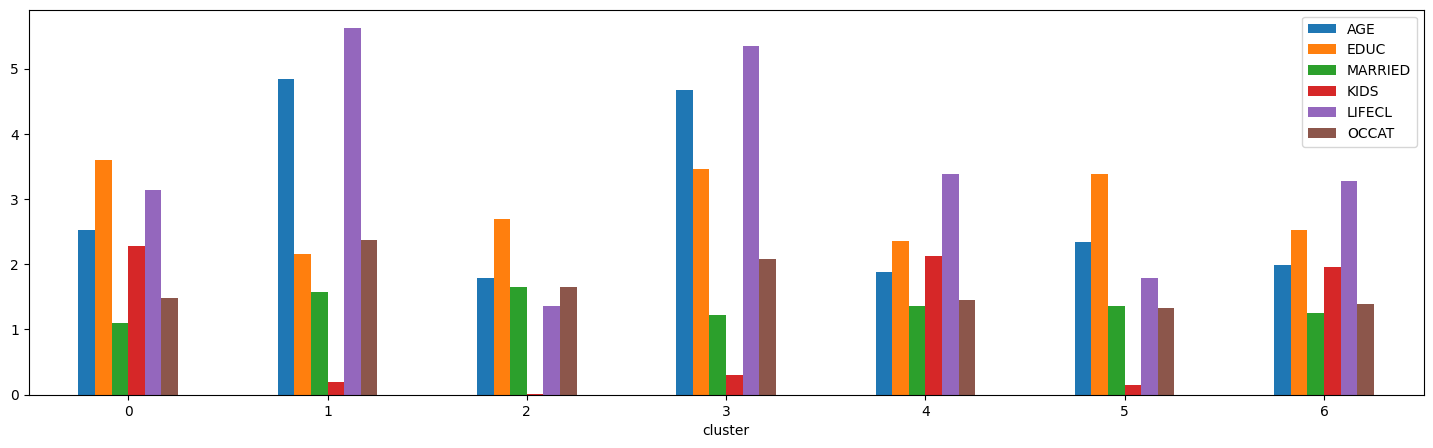

In [66]:
output[['AGE', 'EDUC', 'MARRIED', 'KIDS', 'LIFECL', 'OCCAT']].plot.bar(rot=0, figsize=(18,5)); # Vẽ biểu đồ cột giá trị trung bình các đặc điểm nhân khẩu học theo cụm

Biểu đồ này hiển thị giá trị trung bình của các thuộc tính cho từng cụm.
Ví dụ: So sánh **Cụm 0** và **Cụm 1**:
* Cụm 0 có độ tuổi trung bình thấp hơn nhưng trình độ học vấn trung bình lại cao hơn.
* Về tình trạng hôn nhân và số lượng con cái, hai cụm này khá tương đồng.
* Do đó, xét về các yếu tố nhân khẩu học, các cá nhân trong Cụm 0 trung bình sẽ có **khả năng chịu rủi ro cao hơn** so với Cụm 1.

### Các đặc điểm Tài chính và Sự sẵn lòng chấp nhận rủi ro

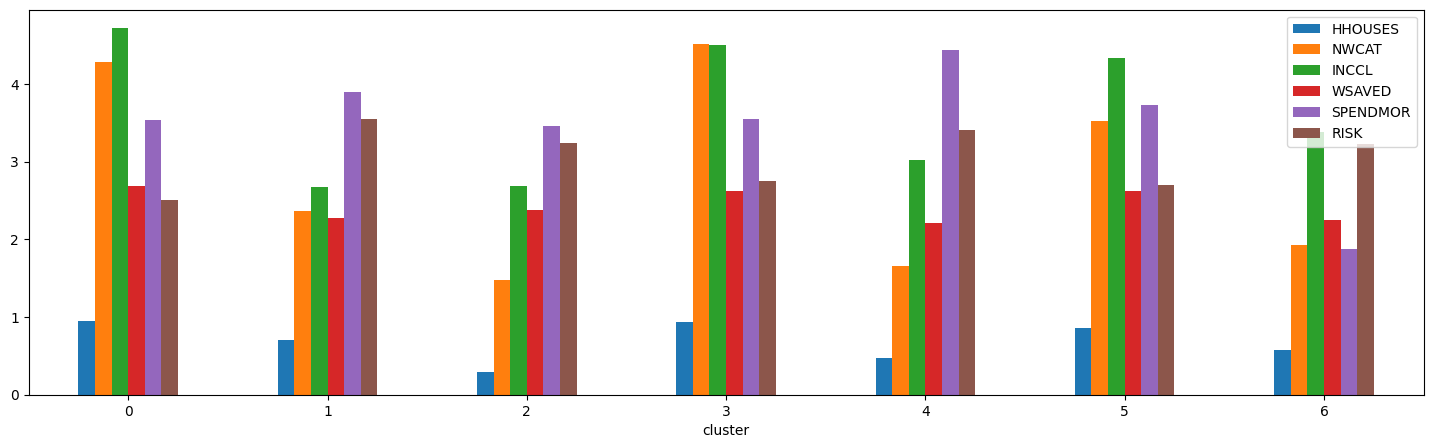

In [67]:
output[['HHOUSES', 'NWCAT', 'INCCL', 'WSAVED', 'SPENDMOR', 'RISK']].plot.bar(rot=0, figsize=(18,5)); # Vẽ biểu đồ cột giá trị trung bình các đặc điểm tài chính và rủi ro theo cụm

Biểu đồ này hiển thị giá trị trung bình của các thuộc tính tài chính và hành vi cho từng cụm.
Ví dụ: So sánh **Cụm 0** và **Cụm 1**:
* Cụm 0 có tỷ lệ sở hữu nhà cao hơn, giá trị tài sản ròng (net worth) và thu nhập cao hơn, nhưng lại có sự sẵn lòng chấp nhận rủi ro thấp hơn.
* Về tỷ lệ tiết kiệm so với thu nhập và ý muốn tiết kiệm, hai cụm này tương đương nhau.
* Do đó, chúng ta có thể giả định rằng các cá nhân trong Cụm 0, trung bình, có **năng lực tài chính cao hơn** nhưng **sự sẵn lòng thấp hơn** để chấp nhận rủi ro so với Cụm 1.

<Axes: xlabel='cluster'>

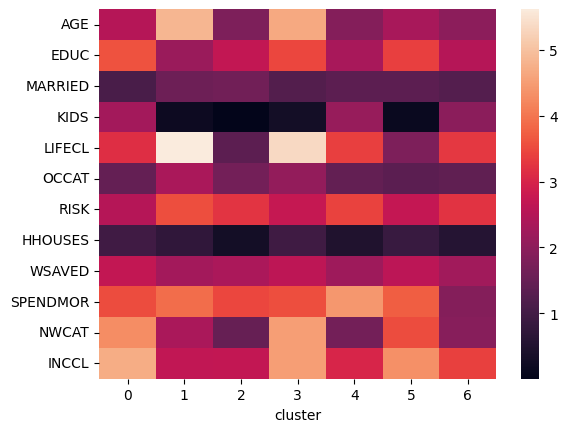

In [68]:
sns.heatmap(output.T) # Vẽ heatmap của ma trận transpose của output để dễ dàng so sánh các cụm

Kết hợp thông tin từ các thuộc tính nhân khẩu học, tài chính và hành vi của Cụm 0 và Cụm 1, năng lực chịu rủi ro tổng thể của cá nhân trong Cụm 0 cao hơn so với Cụm 1. Thực hiện phân tích tương tự cho tất cả các cụm khác, chúng ta tóm tắt kết quả trong bảng dưới đây. Cột "Khả năng chịu rủi ro" đại diện cho đánh giá chủ quan về mức độ chấp nhận rủi ro của từng cụm.

| Cụm (Cluster) | Đặc điểm nổi bật (Features) | Khả năng chịu rủi ro (Risk Capacity) |
| :--- | :--- | :--- |
| **Cluster 0** | Tuổi trẻ, Thu nhập & Tài sản ròng cao, Lối sống ít rủi ro, Sẵn sàng chi tiêu nhiều | **Cao** |
| **Cluster 1** | Tuổi cao, Thu nhập & Tài sản ròng thấp, Lối sống rủi ro cao, Sẵn sàng chấp nhận rủi ro, Học vấn thấp | **Cao** |
| **Cluster 2** | Tuổi cao, Thu nhập & Tài sản ròng cao, Lối sống rủi ro cao, Sẵn sàng chấp nhận rủi ro, Có sở hữu nhà | **Trung bình** |
| **Cluster 3** | Tuổi trẻ, Thu nhập & Tài sản ròng rất thấp, Sẵn sàng chấp nhận rủi ro cao, Nhiều con | **Thấp** |
| **Cluster 4** | Tuổi trung bình, Thu nhập & Tài sản ròng rất cao, Sẵn sàng chấp nhận rủi ro cao, Nhiều con, Có sở hữu nhà | **Cao** |
| **Cluster 5** | Tuổi trẻ, Thu nhập & Tài sản ròng rất thấp, Sẵn sàng chấp nhận rủi ro cao, Không có con | **Trung bình** |
| **Cluster 6** | Tuổi trẻ, Thu nhập & Tài sản ròng trung bình, Sẵn sàng chấp nhận rủi ro cao, Nhiều con, Có sở hữu nhà | **Thấp** |

### Kết luận (Conclusion)

Một trong những bài học chính từ nghiên cứu tình huống này là phương pháp tiếp cận để thấu hiểu bản chất của các cụm (cluster intuition). Chúng ta đã sử dụng các kỹ thuật trực quan hóa để hiểu hành vi kỳ vọng của một thành viên trong cụm thông qua việc diễn giải định tính các giá trị trung bình của các biến số trong mỗi cụm.

Chúng ta đã chứng minh hiệu quả của kỹ thuật phân cụm trong việc khám phá các nhóm nhà đầu tư tự nhiên dựa trên mức độ chấp nhận rủi ro của họ.

Vì các thuật toán phân cụm có thể nhóm thành công các nhà đầu tư dựa trên nhiều yếu tố khác nhau như độ tuổi, thu nhập và khả năng chịu rủi ro, kết quả này có thể được các nhà quản lý danh mục đầu tư sử dụng để thấu hiểu hành vi của nhà đầu tư. Từ đó, họ có thể tiêu chuẩn hóa việc phân bổ danh mục và tái cân bằng tài sản cho từng nhóm cụm, giúp quy trình quản lý đầu tư trở nên nhanh chóng và hiệu quả hơn.